In [2]:
# Import the required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pygam import PoissonGAM,LinearGAM, s, f,te,l
pd.set_option('display.float_format', lambda x: '%.3f' % x)
import arviz as az
from pymc3 import HalfCauchy, Model, Normal, glm, plot_posterior_predictive_glm, sample
import pymc3 as pm

# Load the data into a Pandas dataframe

file = "GAM.xlsx"

df =  pd.read_csv("gam_train.csv")#pd.read_excel(file,sheet_name = "train")


df.head()


df_test = pd.read_csv("gam_test.csv") #pd.read_excel(file,sheet_name = "test")


df.drop(["Market Share"],axis=1,inplace=True)



In [3]:
df

,Date,Competitor TDP,AB TDP,Sales,Marketing,S&P_Package,Sales and Marketing Pakage,NR,SnM/NR,SalesM/HL_lag1,...,SalesM/HL_lag12,SnM_lag1,SnM_lag2,SnM_lag3,SnM_lag4,SnM_lag5,SnP_lag6,SnP_lag12,Total Vol AB STR,SnM/HL
0,01/01/2018,17453,6543,-23918,-77663,-101581,101.581,877887.116,115.711,115.711,...,115.711,101.581,101.581,101.581,101.581,101.581,101.581,101.581,6984.000,15.000
1,01/02/2018,16264,5951,-22768,-73690,-96458,96.458,850434.100,113.422,115.711,...,113.422,101.581,96.458,96.458,96.458,96.458,96.458,96.458,6746.000,14.000
2,01/03/2018,17052,6397,-28644,-93126,-121770,121.770,1055903.758,115.323,113.422,...,115.323,96.458,101.581,121.770,121.770,121.770,121.770,121.770,8317.000,15.000
3,01/04/2018,16498,6209,-27632,-87625,-115257,115.257,984889.338,117.025,115.323,...,117.025,121.770,96.458,101.581,115.257,115.257,115.257,115.257,7764.000,15.000
4,01/05/2018,17500,6512,-33737,-108095,-141832,141.832,1299988.795,109.102,117.025,...,109.102,115.257,121.770,96.458,101.581,141.832,141.832,141.832,10161.000,14.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59,01/12/2022,19865,6365,-24688,-70643,-95331,95.331,1099928.148,86.670,84.713,...,127.540,96.066,121.867,101.009,107.330,102.558,142.788,143.518,7125.000,13.000
60,01/01/2023,20456,6210,-19672,-72309,-91981,76.484,1160694.000,104.693,86.670,...,103.966,95.331,96.066,121.867,101.009,107.330,102.558,85.467,6120.000,12.000
61,01/02/2023,18751,5583,-18965,-70603,-89568,71.326,1050765.000,99.192,104.693,...,86.232,76.484,95.331,96.066,121.867,101.009,107.330,79.703,6112.000,12.000
62,01/03/2023,19685,5989,-21910,-87410,-109320,71.390,1197868.000,84.620,99.192,...,70.522,71.326,76.484,95.331,96.066,121.867,101.009,79.774,7300.086,9.779


In [4]:


# Convert the "Date" column to a datetime object and set it as the index
df['Date'] = pd.to_datetime(df['Date'])


df = df.sort_values("Date")

# features = ["Date","Market Share",
#             "MS vs LY",
# "MS_lag1",
# "MS_lag2",
# "MS_lag3",
# "MS_lag4",
# "MS_lag5",
# "MS_lag6",
# "MS_lag9",
# "MS_lag10",
# "MS_lag11",
# "MS_lag12",
# "SnM_lag5",
# "ABI/TOP COMP TDP",
# "ABI/TOP COMP PRICE"
# ]

# df = df[features]

# df.set_index('Date', inplace=True)

df=  df.drop(["Date"],axis=1)


# Split the data into training and testing sets
val_size = int(len(df) * 0.85)
train_data = df[:val_size]
val_data = df[val_size:]



In [5]:
train_data.head()

,Competitor TDP,AB TDP,Sales,Marketing,S&P_Package,Sales and Marketing Pakage,NR,SnM/NR,SalesM/HL_lag1,SalesM/HL_lag2,...,SalesM/HL_lag12,SnM_lag1,SnM_lag2,SnM_lag3,SnM_lag4,SnM_lag5,SnP_lag6,SnP_lag12,Total Vol AB STR,SnM/HL
0,17453,6543,-23918,-77663,-101581,101.581,877887.116,115.711,115.711,115.711,...,115.711,101.581,101.581,101.581,101.581,101.581,101.581,101.581,6984.000,15.000
1,16264,5951,-22768,-73690,-96458,96.458,850434.100,113.422,115.711,113.422,...,113.422,101.581,96.458,96.458,96.458,96.458,96.458,96.458,6746.000,14.000
2,17052,6397,-28644,-93126,-121770,121.770,1055903.758,115.323,113.422,115.711,...,115.323,96.458,101.581,121.770,121.770,121.770,121.770,121.770,8317.000,15.000
3,16498,6209,-27632,-87625,-115257,115.257,984889.338,117.025,115.323,113.422,...,117.025,121.770,96.458,101.581,115.257,115.257,115.257,115.257,7764.000,15.000
4,17500,6512,-33737,-108095,-141832,141.832,1299988.795,109.102,117.025,115.323,...,109.102,115.257,121.770,96.458,101.581,141.832,141.832,141.832,10161.000,14.000


In [6]:
val_data

,Competitor TDP,AB TDP,Sales,Marketing,S&P_Package,Sales and Marketing Pakage,NR,SnM/NR,SalesM/HL_lag1,SalesM/HL_lag2,...,SalesM/HL_lag12,SnM_lag1,SnM_lag2,SnM_lag3,SnM_lag4,SnM_lag5,SnP_lag6,SnP_lag12,Total Vol AB STR,SnM/HL
54,20315,6639,-26956,-75602,-102558,102.558,1127613.285,90.951,108.027,89.605,...,103.863,142.788,110.731,113.453,79.774,79.703,85.467,125.982,7692.000,13.000
55,20613,6691,-30185,-77145,-107330,107.330,1258766.313,85.266,90.951,108.027,...,101.304,102.558,142.788,110.731,113.453,79.774,79.703,119.560,8627.000,12.000
56,19628,6382,-26445,-74564,-101009,101.009,1209175.716,83.535,85.266,90.951,...,99.437,107.330,102.558,142.788,110.731,113.453,79.774,113.600,8311.000,12.000
57,20116,6527,-23116,-98751,-121867,121.867,1016859.127,119.846,83.535,85.266,...,98.075,101.009,107.330,102.558,142.788,110.731,113.453,103.412,6538.000,19.000
58,19288,6240,-24249,-71817,-96066,96.066,1134019.251,84.713,119.846,83.535,...,99.149,121.867,101.009,107.330,102.558,142.788,110.731,105.878,7238.000,13.000
59,19865,6365,-24688,-70643,-95331,95.331,1099928.148,86.670,84.713,119.846,...,127.540,96.066,121.867,101.009,107.330,102.558,142.788,143.518,7125.000,13.000
60,20456,6210,-19672,-72309,-91981,76.484,1160694.000,104.693,86.670,84.713,...,103.966,95.331,96.066,121.867,101.009,107.330,102.558,85.467,6120.000,12.000
61,18751,5583,-18965,-70603,-89568,71.326,1050765.000,99.192,104.693,86.670,...,86.232,76.484,95.331,96.066,121.867,101.009,107.330,79.703,6112.000,12.000
62,19685,5989,-21910,-87410,-109320,71.390,1197868.000,84.620,99.192,104.693,...,70.522,71.326,76.484,95.331,96.066,121.867,101.009,79.774,7300.086,9.779
63,19309,5932,-26151,-91222,-117373,101.529,1138190.409,105.267,84.620,99.192,...,104.616,71.390,71.326,76.484,95.331,96.066,121.867,113.453,6944.652,14.620


In [7]:
val_data.columns

Index(['Competitor TDP', 'AB TDP', 'Sales', 'Marketing', 'S&P_Package',
       'Sales and Marketing Pakage', 'NR', 'SnM/NR', 'SalesM/HL_lag1',
       'SalesM/HL_lag2', 'SalesM/HL_lag3', 'SalesM/HL_lag4', 'SalesM/HL_lag5',
       'SalesM/HL_lag6', 'SalesM/HL_lag12', 'SnM_lag1', 'SnM_lag2', 'SnM_lag3',
       'SnM_lag4', 'SnM_lag5', 'SnP_lag6', 'SnP_lag12', 'Total Vol AB STR',
       'SnM/HL'],
      dtype='object')

In [8]:
gam= LinearGAM(s(0,n_splines=4,
    spline_order=3) + s(1, n_splines=5,
    spline_order=3) + s(2, n_splines=5,
    spline_order=3) + s(3, n_splines=5,
    spline_order=3)+  s(4, n_splines=5,
    spline_order=3)  + s(5, n_splines=5,
    spline_order=3) + s(6, n_splines=5,
    spline_order=3) 
               ,verbose=True).fit(
    train_data.drop(['Total Vol AB STR'],axis=1).values, train_data['Total Vol AB STR'])


c:\Users\HP\anaconda3\envs\bayesian\Lib\site-packages\pygam\utils.py:80: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)


In [9]:
# gam= LinearGAM(l(0, 
#     lam=0.3) + s(1, n_splines=30,
#     spline_order=26,
#     lam=0.3) + s(2, n_splines=30,
#     spline_order=26,
#     lam=0.3) + s(3, n_splines=30,
#     spline_order=26,
#     lam=0.3)  + s(5, n_splines=30,
#     spline_order=26,
#     lam=0.3) + s(6, n_splines=30,
#     spline_order=26,
#     lam=0.3) +te(7, 8, n_splines=10)
#                ,verbose=True).fit(
#     train_data.drop(['Total Vol AB STR'],axis=1).values, train_data['Total Vol AB STR'])


In [10]:
gam.summary()

LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                      7.7832
Link Function:                     IdentityLink Log Likelihood:                                  -588.0551
Number of Samples:                           54 AIC:                                             1193.6766
                                                AICc:                                            1197.5632
                                                GCV:                                            28740.6828
                                                Scale:                                          21395.8078
                                                Pseudo R-Squared:                                   0.9811
Feature Function                  Lam

C:\Users\HP\AppData\Local\Temp\ipykernel_7560\3358381670.py:1: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  gam.summary()


In [11]:
pred_val = gam.predict(val_data.drop(['Total Vol AB STR'],axis=1).values)

In [12]:
true_val = (val_data['Total Vol AB STR'].values)

In [13]:
#mape calulations
np.mean(np.abs((true_val -pred_val) / true_val)) * 100

6.1529768035389365

0 (54,) (54,)


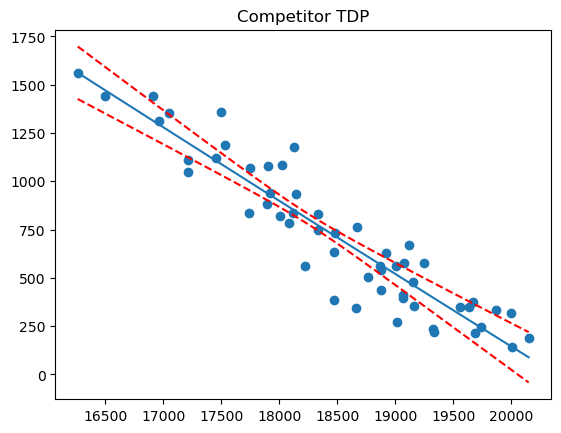

1 (54,) (54,)


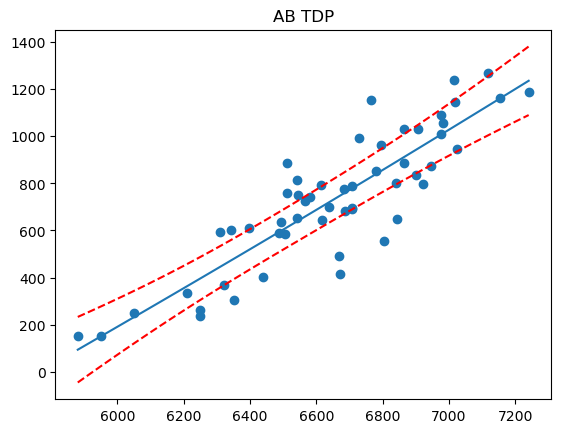

2 (54,) (54,)


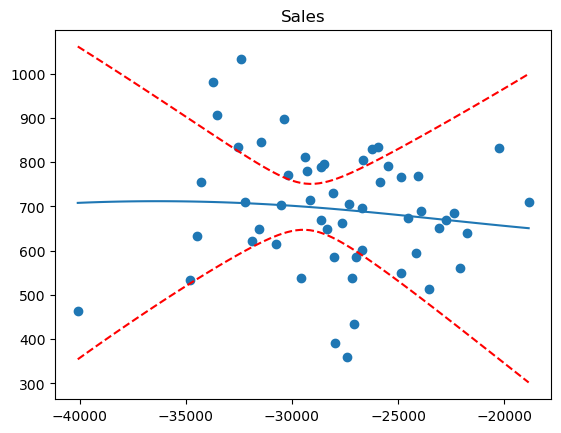

3 (54,) (54,)


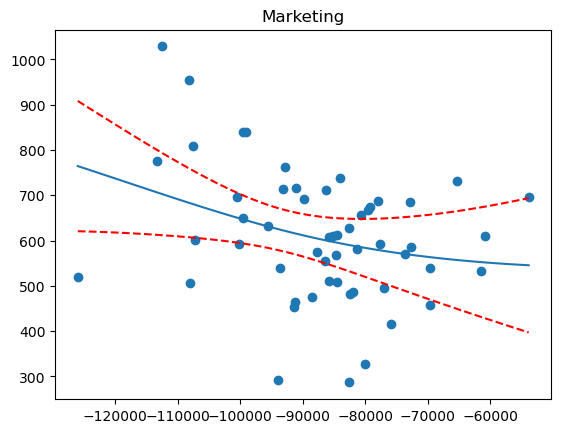

4 (54,) (54,)


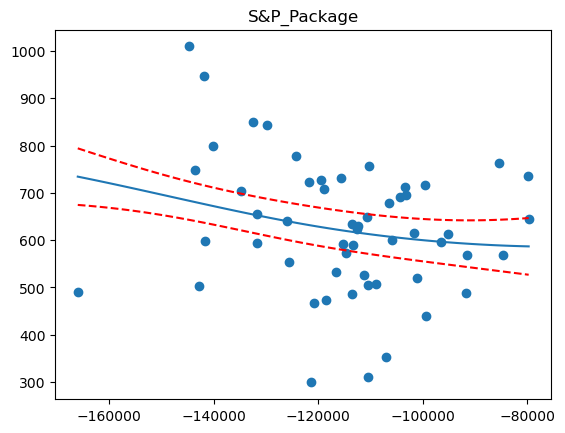

5 (54,) (54,)


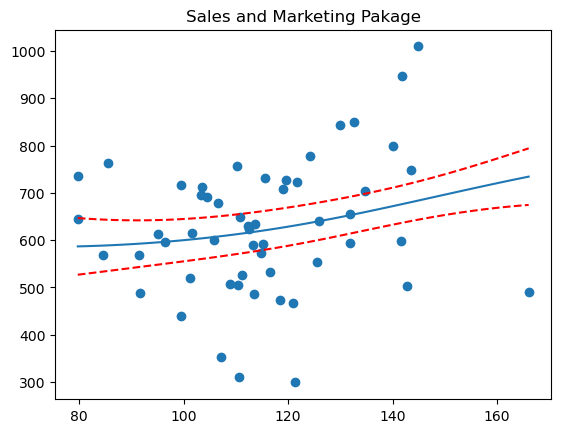

6 (54,) (54,)


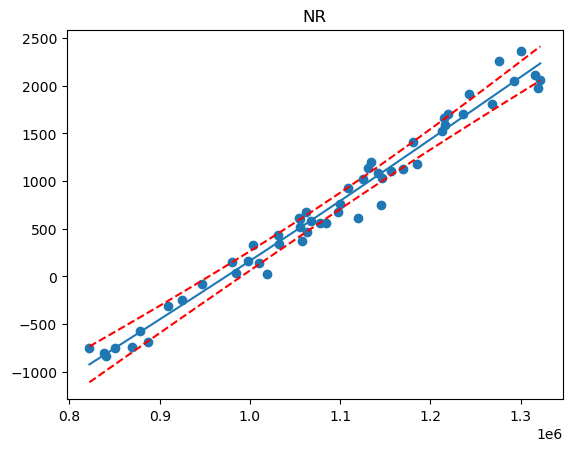

In [14]:
X , y = train_data.drop(['Total Vol AB STR'],axis=1), train_data['Total Vol AB STR'] 

res = gam.deviance_residuals(X,y)
for i, term in enumerate(gam.terms):

    if term.isintercept:
        continue

    XX = gam.generate_X_grid(term=i)
    pdep, confi = gam.partial_dependence(term=i, X=XX, width=0.95)
    pdep2, _ = gam.partial_dependence(term=i, X=X, width=0.95)
    plt.figure()
    print(term.feature,X.iloc[:,term.feature].shape, (pdep2 + res).shape)
    if isinstance(term.feature,int):   
        plt.scatter(X.iloc[:,term.feature], pdep2 + res)
        plt.plot(XX[:, term.feature], pdep)
        plt.plot(XX[:, term.feature], confi, c='r', ls='--')
        plt.title(X.columns.values[term.feature])
        plt.show()
   

In [15]:
val_data

,Competitor TDP,AB TDP,Sales,Marketing,S&P_Package,Sales and Marketing Pakage,NR,SnM/NR,SalesM/HL_lag1,SalesM/HL_lag2,...,SalesM/HL_lag12,SnM_lag1,SnM_lag2,SnM_lag3,SnM_lag4,SnM_lag5,SnP_lag6,SnP_lag12,Total Vol AB STR,SnM/HL
54,20315,6639,-26956,-75602,-102558,102.558,1127613.285,90.951,108.027,89.605,...,103.863,142.788,110.731,113.453,79.774,79.703,85.467,125.982,7692.000,13.000
55,20613,6691,-30185,-77145,-107330,107.330,1258766.313,85.266,90.951,108.027,...,101.304,102.558,142.788,110.731,113.453,79.774,79.703,119.560,8627.000,12.000
56,19628,6382,-26445,-74564,-101009,101.009,1209175.716,83.535,85.266,90.951,...,99.437,107.330,102.558,142.788,110.731,113.453,79.774,113.600,8311.000,12.000
57,20116,6527,-23116,-98751,-121867,121.867,1016859.127,119.846,83.535,85.266,...,98.075,101.009,107.330,102.558,142.788,110.731,113.453,103.412,6538.000,19.000
58,19288,6240,-24249,-71817,-96066,96.066,1134019.251,84.713,119.846,83.535,...,99.149,121.867,101.009,107.330,102.558,142.788,110.731,105.878,7238.000,13.000
59,19865,6365,-24688,-70643,-95331,95.331,1099928.148,86.670,84.713,119.846,...,127.540,96.066,121.867,101.009,107.330,102.558,142.788,143.518,7125.000,13.000
60,20456,6210,-19672,-72309,-91981,76.484,1160694.000,104.693,86.670,84.713,...,103.966,95.331,96.066,121.867,101.009,107.330,102.558,85.467,6120.000,12.000
61,18751,5583,-18965,-70603,-89568,71.326,1050765.000,99.192,104.693,86.670,...,86.232,76.484,95.331,96.066,121.867,101.009,107.330,79.703,6112.000,12.000
62,19685,5989,-21910,-87410,-109320,71.390,1197868.000,84.620,99.192,104.693,...,70.522,71.326,76.484,95.331,96.066,121.867,101.009,79.774,7300.086,9.779
63,19309,5932,-26151,-91222,-117373,101.529,1138190.409,105.267,84.620,99.192,...,104.616,71.390,71.326,76.484,95.331,96.066,121.867,113.453,6944.652,14.620


In [16]:
val_data.head(100)

,Competitor TDP,AB TDP,Sales,Marketing,S&P_Package,Sales and Marketing Pakage,NR,SnM/NR,SalesM/HL_lag1,SalesM/HL_lag2,...,SalesM/HL_lag12,SnM_lag1,SnM_lag2,SnM_lag3,SnM_lag4,SnM_lag5,SnP_lag6,SnP_lag12,Total Vol AB STR,SnM/HL
54,20315,6639,-26956,-75602,-102558,102.558,1127613.285,90.951,108.027,89.605,...,103.863,142.788,110.731,113.453,79.774,79.703,85.467,125.982,7692.000,13.000
55,20613,6691,-30185,-77145,-107330,107.330,1258766.313,85.266,90.951,108.027,...,101.304,102.558,142.788,110.731,113.453,79.774,79.703,119.560,8627.000,12.000
56,19628,6382,-26445,-74564,-101009,101.009,1209175.716,83.535,85.266,90.951,...,99.437,107.330,102.558,142.788,110.731,113.453,79.774,113.600,8311.000,12.000
57,20116,6527,-23116,-98751,-121867,121.867,1016859.127,119.846,83.535,85.266,...,98.075,101.009,107.330,102.558,142.788,110.731,113.453,103.412,6538.000,19.000
58,19288,6240,-24249,-71817,-96066,96.066,1134019.251,84.713,119.846,83.535,...,99.149,121.867,101.009,107.330,102.558,142.788,110.731,105.878,7238.000,13.000
59,19865,6365,-24688,-70643,-95331,95.331,1099928.148,86.670,84.713,119.846,...,127.540,96.066,121.867,101.009,107.330,102.558,142.788,143.518,7125.000,13.000
60,20456,6210,-19672,-72309,-91981,76.484,1160694.000,104.693,86.670,84.713,...,103.966,95.331,96.066,121.867,101.009,107.330,102.558,85.467,6120.000,12.000
61,18751,5583,-18965,-70603,-89568,71.326,1050765.000,99.192,104.693,86.670,...,86.232,76.484,95.331,96.066,121.867,101.009,107.330,79.703,6112.000,12.000
62,19685,5989,-21910,-87410,-109320,71.390,1197868.000,84.620,99.192,104.693,...,70.522,71.326,76.484,95.331,96.066,121.867,101.009,79.774,7300.086,9.779
63,19309,5932,-26151,-91222,-117373,101.529,1138190.409,105.267,84.620,99.192,...,104.616,71.390,71.326,76.484,95.331,96.066,121.867,113.453,6944.652,14.620


In [17]:
###betas for range of independent variables

(gam.coef_).shape,train_data.shape

((35,), (54, 24))

In [18]:
gam.statistics_

{'n_samples': 54,
 'm_features': 23,
 'edof_per_coef': array([8.92815560e-01, 8.04203864e-01, 5.39125947e-01, 6.70933000e-02,
        5.21781606e-01, 6.41882569e-01, 2.95479958e-01, 4.86665889e-02,
        9.57846838e-02, 6.10123708e-01, 6.09382457e-01, 4.01511894e-01,
        4.81139234e-02, 6.17162496e-03, 4.04410908e-01, 4.42730206e-01,
        4.32749466e-01, 1.19378557e-02, 1.16434325e-02, 2.17915397e-01,
        1.91920416e-03, 6.75825666e-02, 1.05788539e-02, 1.34883595e-02,
        6.48279387e-03, 4.71533791e-03, 3.03921842e-02, 2.37717074e-02,
        2.80166437e-02, 1.05575326e-01, 1.98999864e-01, 1.79147327e-01,
        9.01747561e-03, 1.00094279e-23, 5.92677588e-24]),
 'edof': 7.783212594493052,
 'scale': 21395.80782450661,
 'cov': array([[ 39151.15004758,  13083.97127082, -12629.41264763, ...,
           8735.39012336,  19650.10871327,   1613.94414046],
        [ 13083.97127082,   4633.3652046 ,  -4049.576454  , ...,
           2904.65029799,   6594.47824316,    677.2194591

In [19]:
y_sum = train_data["Total Vol AB STR"].sum()
y_sum

436230.0

In [20]:
d1=X.head(1)
d1

,Competitor TDP,AB TDP,Sales,Marketing,S&P_Package,Sales and Marketing Pakage,NR,SnM/NR,SalesM/HL_lag1,SalesM/HL_lag2,...,SalesM/HL_lag6,SalesM/HL_lag12,SnM_lag1,SnM_lag2,SnM_lag3,SnM_lag4,SnM_lag5,SnP_lag6,SnP_lag12,SnM/HL
0,17453,6543,-23918,-77663,-101581,101.581,877887.116,115.711,115.711,115.711,...,115.711,115.711,101.581,101.581,101.581,101.581,101.581,101.581,101.581,15.000


In [21]:
d1["SalesM/HL_lag2"] = d1["SalesM/HL_lag2"]*1.10

C:\Users\HP\AppData\Local\Temp\ipykernel_7560\1248319319.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d1["SalesM/HL_lag2"] = d1["SalesM/HL_lag2"]*1.10


In [22]:
d1

,Competitor TDP,AB TDP,Sales,Marketing,S&P_Package,Sales and Marketing Pakage,NR,SnM/NR,SalesM/HL_lag1,SalesM/HL_lag2,...,SalesM/HL_lag6,SalesM/HL_lag12,SnM_lag1,SnM_lag2,SnM_lag3,SnM_lag4,SnM_lag5,SnP_lag6,SnP_lag12,SnM/HL
0,17453,6543,-23918,-77663,-101581,101.581,877887.116,115.711,115.711,127.282,...,115.711,115.711,101.581,101.581,101.581,101.581,101.581,101.581,101.581,15.000


In [23]:
gam.predict(d1),gam.predict(X.head(1))

(array([6970.68465934]), array([6970.68465934]))

In [24]:

elasti = []
for i,col in enumerate(X.columns):
    base_val = X[col]  
    X[col] = base_val*1.01
    y_dash_sum = gam.predict(X).sum()
    fy = (y_dash_sum - y_sum)*100/y_sum

    elasti.append((X.columns[i],fy))
            
    X[col] = base_val
    

In [25]:
X.head(1)

,Competitor TDP,AB TDP,Sales,Marketing,S&P_Package,Sales and Marketing Pakage,NR,SnM/NR,SalesM/HL_lag1,SalesM/HL_lag2,...,SalesM/HL_lag6,SalesM/HL_lag12,SnM_lag1,SnM_lag2,SnM_lag3,SnM_lag4,SnM_lag5,SnP_lag6,SnP_lag12,SnM/HL
0,17453,6543,-23918,-77663,-101581,101.581,877887.116,115.711,115.711,115.711,...,115.711,115.711,101.581,101.581,101.581,101.581,101.581,101.581,101.581,15.000


In [26]:
elasticity_table = pd.DataFrame(elasti[:7],columns=['Variable', 'Elasticity'])

In [27]:
elasti[:7]

[('Competitor TDP', -0.8663476928236661),
 ('AB TDP', 0.696759124108574),
 ('Sales', 0.011780247817841937),
 ('Marketing', 0.03342786536889353),
 ('S&P_Package', 0.02370828530465664),
 ('Sales and Marketing Pakage', 0.02370828503983133),
 ('NR', 0.8575409622321248)]

In [28]:
elasticity_table

,Variable,Elasticity
0,Competitor TDP,-0.866
1,AB TDP,0.697
2,Sales,0.012
3,Marketing,0.033
4,S&P_Package,0.024
5,Sales and Marketing Pakage,0.024
6,NR,0.858


In [29]:
features_to_consider = list(elasticity_table.Variable.values)

In [30]:
X_act = X[features_to_consider]
gam = LinearGAM(s(0,n_splines=4,
    spline_order=3) + s(1, n_splines=5,
    spline_order=3) + s(2, n_splines=5,
    spline_order=3) + s(3, n_splines=5,
    spline_order=3)+  s(4, n_splines=5,
    spline_order=3)  + s(5, n_splines=5,
    spline_order=3) + s(6, n_splines=5,
    spline_order=3) 
               ,verbose=True).fit(
    X_act.values, train_data['Total Vol AB STR'])

c:\Users\HP\anaconda3\envs\bayesian\Lib\site-packages\pygam\utils.py:80: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)


In [31]:
gam.summary()

LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                      7.7832
Link Function:                     IdentityLink Log Likelihood:                                  -588.0551
Number of Samples:                           54 AIC:                                             1193.6766
                                                AICc:                                            1197.5632
                                                GCV:                                            28740.6828
                                                Scale:                                          21395.8078
                                                Pseudo R-Squared:                                   0.9811
Feature Function                  Lam

C:\Users\HP\AppData\Local\Temp\ipykernel_7560\3358381670.py:1: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  gam.summary()


In [32]:
gam.predict(df_test[features_to_consider])

array([7834.40850948, 7960.9427954 , 8297.47592822, 7861.1396599 ,
       7249.79390313, 8182.02833192, 7041.64813245, 6453.58903093,
       7228.4375445 , 6275.79970565, 6842.1050102 , 7897.09972463,
       7123.01601783, 6785.93847163, 8470.85394629, 6962.4278482 ,
       6747.25012567, 8090.92531347, 6250.80333929, 6268.76113641])

In [33]:
pred_val = gam.predict(val_data[features_to_consider].values)
true_val = (val_data['Total Vol AB STR'].values)

#data science mape calulations
np.mean(np.abs((true_val -pred_val) / true_val)) * 100,100- np.mean(np.abs((true_val -pred_val) / true_val)) * 100

(6.1529768035389365, 93.84702319646107)

In [34]:
(true_val.sum()- pred_val.sum())/true_val.sum() ### abi accuracy

-0.039751676763287745

In [35]:
import pickle

with open('gam_usa_2023.pkl', 'wb') as files:
    pickle.dump(gam, files)

In [36]:
# pred_val = gam.predict(train_data[features_to_consider].values)
# true_val = (train_data['Total Vol AB STR'].values)

# #mape calulations
# np.mean(np.abs((true_val -pred_val) / true_val)) * 100,100- np.mean(np.abs((true_val -pred_val) / true_val)) * 100

In [37]:
val_data[features_to_consider]


,Competitor TDP,AB TDP,Sales,Marketing,S&P_Package,Sales and Marketing Pakage,NR
54,20315,6639,-26956,-75602,-102558,102.558,1127613.285
55,20613,6691,-30185,-77145,-107330,107.330,1258766.313
56,19628,6382,-26445,-74564,-101009,101.009,1209175.716
57,20116,6527,-23116,-98751,-121867,121.867,1016859.127
58,19288,6240,-24249,-71817,-96066,96.066,1134019.251
59,19865,6365,-24688,-70643,-95331,95.331,1099928.148
60,20456,6210,-19672,-72309,-91981,76.484,1160694.000
61,18751,5583,-18965,-70603,-89568,71.326,1050765.000
62,19685,5989,-21910,-87410,-109320,71.390,1197868.000
63,19309,5932,-26151,-91222,-117373,101.529,1138190.409


In [38]:
val_data["Forecast"] = pred_val

C:\Users\HP\AppData\Local\Temp\ipykernel_7560\1820474764.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_data["Forecast"] = pred_val


In [39]:
val_data

,Competitor TDP,AB TDP,Sales,Marketing,S&P_Package,Sales and Marketing Pakage,NR,SnM/NR,SalesM/HL_lag1,SalesM/HL_lag2,...,SnM_lag1,SnM_lag2,SnM_lag3,SnM_lag4,SnM_lag5,SnP_lag6,SnP_lag12,Total Vol AB STR,SnM/HL,Forecast
54,20315,6639,-26956,-75602,-102558,102.558,1127613.285,90.951,108.027,89.605,...,142.788,110.731,113.453,79.774,79.703,85.467,125.982,7692.000,13.000,7536.567
55,20613,6691,-30185,-77145,-107330,107.330,1258766.313,85.266,90.951,108.027,...,102.558,142.788,110.731,113.453,79.774,79.703,119.560,8627.000,12.000,8347.724
56,19628,6382,-26445,-74564,-101009,101.009,1209175.716,83.535,85.266,90.951,...,107.330,102.558,142.788,110.731,113.453,79.774,113.600,8311.000,12.000,8098.768
57,20116,6527,-23116,-98751,-121867,121.867,1016859.127,119.846,83.535,85.266,...,101.009,107.330,102.558,142.788,110.731,113.453,103.412,6538.000,19.000,6925.758
58,19288,6240,-24249,-71817,-96066,96.066,1134019.251,84.713,119.846,83.535,...,121.867,101.009,107.330,102.558,142.788,110.731,105.878,7238.000,13.000,7597.326
59,19865,6365,-24688,-70643,-95331,95.331,1099928.148,86.670,84.713,119.846,...,96.066,121.867,101.009,107.330,102.558,142.788,143.518,7125.000,13.000,7264.476
60,20456,6210,-19672,-72309,-91981,76.484,1160694.000,104.693,86.670,84.713,...,95.331,96.066,121.867,101.009,107.330,102.558,85.467,6120.000,12.000,7271.429
61,18751,5583,-18965,-70603,-89568,71.326,1050765.000,99.192,104.693,86.670,...,76.484,95.331,96.066,121.867,101.009,107.330,79.703,6112.000,12.000,6689.501
62,19685,5989,-21910,-87410,-109320,71.390,1197868.000,84.620,99.192,104.693,...,71.326,76.484,95.331,96.066,121.867,101.009,79.774,7300.086,9.779,7683.695
63,19309,5932,-26151,-91222,-117373,101.529,1138190.409,105.267,84.620,99.192,...,71.390,71.326,76.484,95.331,96.066,121.867,113.453,6944.652,14.620,7454.923


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag_grad...


Convergence achieved at 26700
Interrupted at 26,699 [13%]: Average Loss = 8.9524e+05
Sequential sampling (4 chains in 1 job)
NUTS: [c_weight, c_forecast, Intercept, sigma]


Sampling 4 chains for 4_000 tune and 1_000 draw iterations (16_000 + 4_000 draws total) took 25 seconds.
c:\Users\HP\anaconda3\envs\bayesian\Lib\site-packages\arviz\utils.py:180: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)
c:\Users\HP\anaconda3\envs\bayesian\Lib\site-packages\arviz\utils.py:180: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviou

array([[<Axes: title={'center': 'Intercept'}>,
        <Axes: title={'center': 'Intercept'}>],
       [<Axes: title={'center': 'c_forecast'}>,
        <Axes: title={'center': 'c_forecast'}>],
       [<Axes: title={'center': 'c_weight'}>,
        <Axes: title={'center': 'c_weight'}>],
       [<Axes: title={'center': 'sigma'}>,
        <Axes: title={'center': 'sigma'}>]], dtype=object)

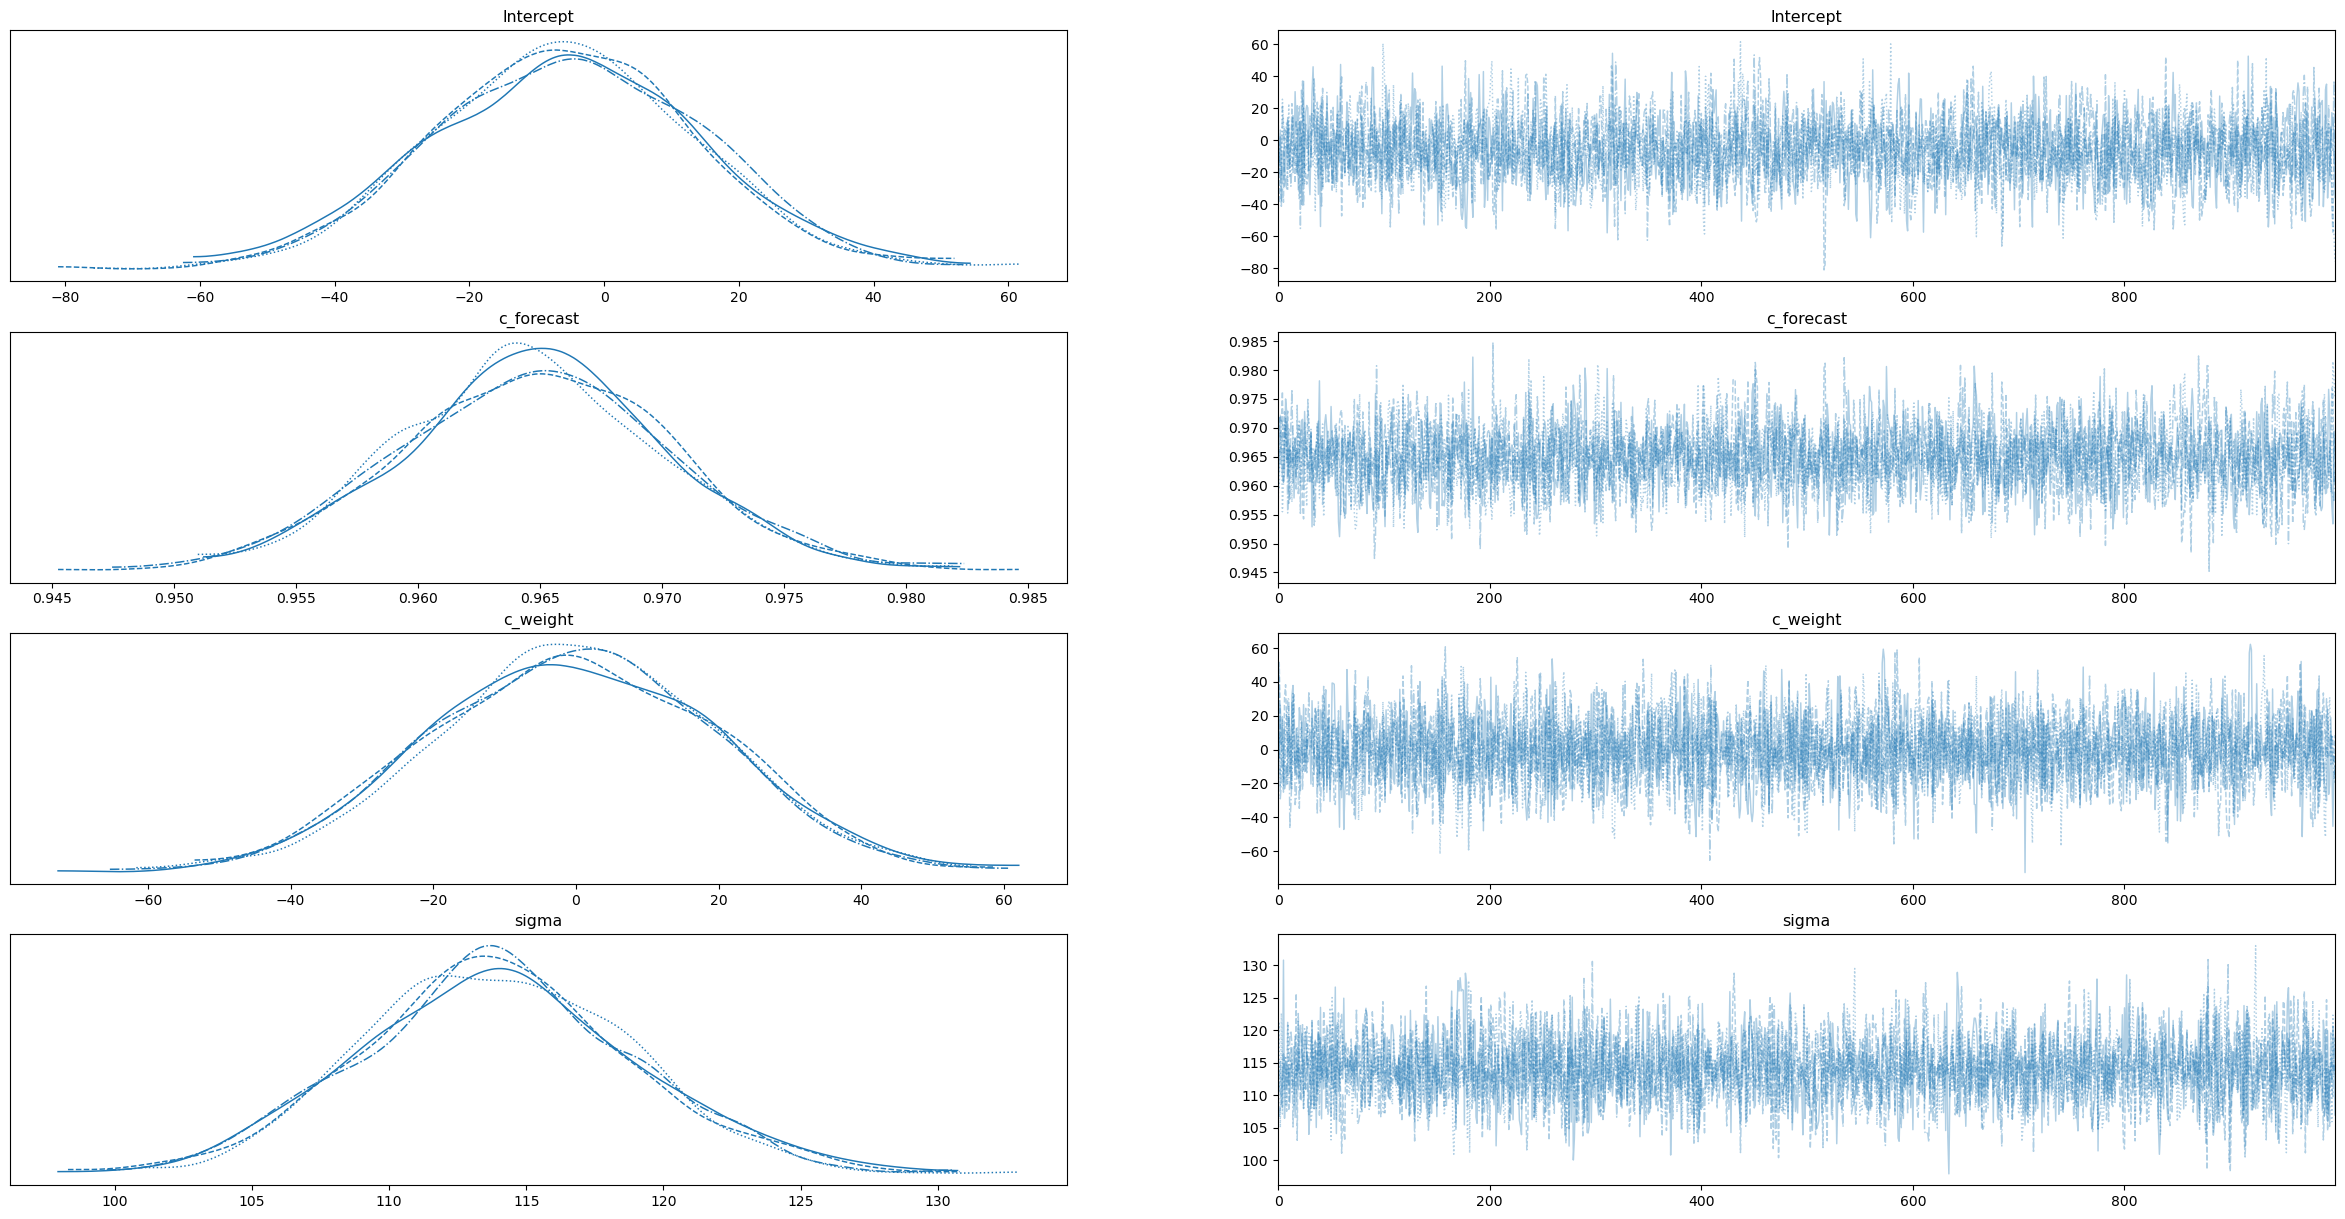

In [40]:
with Model() as model:
        # Define priors
        # sigma = pm.HalfCauchy("sigma", beta=10, testval=1.0)
        # sigma = pm.HalfNormal("sigma", sigma=10)
        sigma = pm.HalfNormal("sigma", sigma=10)
        intercept = Normal("Intercept", 0, sigma=20)
        # intercept = Normal("Intercept", 0, sigma=5)
        # x_coeff = Normal("x", 0, sigma=10)
        # forecast_coeff = Normal("c_forecast", 0, sigma=20)
        forecast_coeff = Normal("c_forecast", 0, sigma=20)
        weight_coeff = Normal("c_weight", 0, sigma=20)
        x_forecast = pm.Data("x_forecast",val_data["Forecast"])
        # x_weight = pm.Data("x_weight", train_df["weight"])
        # Define likelihood
        likelihood = Normal("y", mu=intercept + forecast_coeff * x_forecast, sigma=sigma, observed=val_data["Total Vol AB STR"])
        #trace = sample(draws=1000, tune=3000, return_inferencedata=True, target_accept=0.95, cores=1, chains=4)
        trace = sample(draws=1000, tune=4000, return_inferencedata=True, target_accept=0.95, cores=1, chains=4, init="advi+adapt_diag_grad")
az.plot_trace(trace, figsize=(30, 15))

In [41]:
df.head()

,Competitor TDP,AB TDP,Sales,Marketing,S&P_Package,Sales and Marketing Pakage,NR,SnM/NR,SalesM/HL_lag1,SalesM/HL_lag2,...,SalesM/HL_lag12,SnM_lag1,SnM_lag2,SnM_lag3,SnM_lag4,SnM_lag5,SnP_lag6,SnP_lag12,Total Vol AB STR,SnM/HL
0,17453,6543,-23918,-77663,-101581,101.581,877887.116,115.711,115.711,115.711,...,115.711,101.581,101.581,101.581,101.581,101.581,101.581,101.581,6984.000,15.000
1,16264,5951,-22768,-73690,-96458,96.458,850434.100,113.422,115.711,113.422,...,113.422,101.581,96.458,96.458,96.458,96.458,96.458,96.458,6746.000,14.000
2,17052,6397,-28644,-93126,-121770,121.770,1055903.758,115.323,113.422,115.711,...,115.323,96.458,101.581,121.770,121.770,121.770,121.770,121.770,8317.000,15.000
3,16498,6209,-27632,-87625,-115257,115.257,984889.338,117.025,115.323,113.422,...,117.025,121.770,96.458,101.581,115.257,115.257,115.257,115.257,7764.000,15.000
4,17500,6512,-33737,-108095,-141832,141.832,1299988.795,109.102,117.025,115.323,...,109.102,115.257,121.770,96.458,101.581,141.832,141.832,141.832,10161.000,14.000


In [42]:
trace

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data
	> constant_data

In [43]:
df = val_data.copy()

new_data_forecast = df.loc[:, "Forecast"]
# new_data_weight = df.loc[:, "weight"]
with model:
    pm.set_data({"x_forecast": new_data_forecast})
    post_pred = pm.sample_posterior_predictive(trace)
y_pred = post_pred["y"]
y_mean = y_pred.mean(axis=0)
y_std = y_pred.std(axis=0)
# hdi_prob = HDI_DICT[country_name]
hdi_prob = az.hdi(y_pred, hdi_prob=0.95)
hdi_lower_limit = hdi_prob[:, 0]
hdi_upper_limit = hdi_prob[:, 1]


C:\Users\HP\AppData\Local\Temp\ipykernel_7560\4149282875.py:12: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_prob = az.hdi(y_pred, hdi_prob=0.95)


In [44]:
hdi_upper_limit, hdi_lower_limit

(array([7489.42111775, 8292.02266609, 8031.1724285 , 6912.18516951,
        7566.68880818, 7230.39019347, 7246.10452921, 6666.03240429,
        7654.10008575, 7417.15074867]),
 array([7021.03368769, 7824.98309497, 7549.88370319, 6449.64815791,
        7093.52899369, 6765.40628997, 6782.06811261, 6214.06195187,
        7187.73980584, 6945.47307005]))

In [45]:
range_df = pd.DataFrame({"hdi_lower_limit":hdi_lower_limit,"hdi_upper_limit":hdi_upper_limit})
range_df["actuals"] = val_data["Total Vol AB STR"].reset_index(drop=True)

range_df

,hdi_lower_limit,hdi_upper_limit,actuals
0,7021.034,7489.421,7692.000
1,7824.983,8292.023,8627.000
2,7549.884,8031.172,8311.000
3,6449.648,6912.185,6538.000
4,7093.529,7566.689,7238.000
5,6765.406,7230.390,7125.000
6,6782.068,7246.105,6120.000
7,6214.062,6666.032,6112.000
8,7187.740,7654.100,7300.086
9,6945.473,7417.151,6944.652


In [46]:
range_df["diff"] = range_df["hdi_upper_limit"]-range_df["actuals"]
range_df["hdi_lower_limit"].sum(),range_df["hdi_upper_limit"].sum(),range_df.actuals.sum()

(69833.82686780367, 74505.26815142302, 72007.738449)

In [47]:


# # Calculate the HDI for the first predictor
# for i in range(len(val_data)):
#     hdi = az.hdi(gam.predict(val_data[features_to_consider].head(i+1)), hdi_prob=0.75)

#     # Print the HDI for the first predictor
#     print("75% HDI for the predictors:")
#     print(hdi)

In [48]:
# import numpy as np
# import pandas as pd
# import rpy2.robjects as ro
# from rpy2.robjects import numpy2ri, pandas2ri
# from rpy2.robjects.packages import importr

# # Activate automatic conversion between numpy arrays and R objects
# numpy2ri.activate()
# pandas2ri.activate()

# # Generate some example data
# np.random.seed(0)
# n_samples = 100
# n_timesteps = 5
# X = np.linspace(0, 10, n_samples)
# X_dyn = X.flatten()
# y = np.sin(X) + np.random.normal(0, 0.2, n_samples)


ModuleNotFoundError: No module named 'rpy2'

In [ ]:

# Convert data to pandas DataFrame
data = pd.DataFrame({'X_dyn': X_dyn, 'y': y})


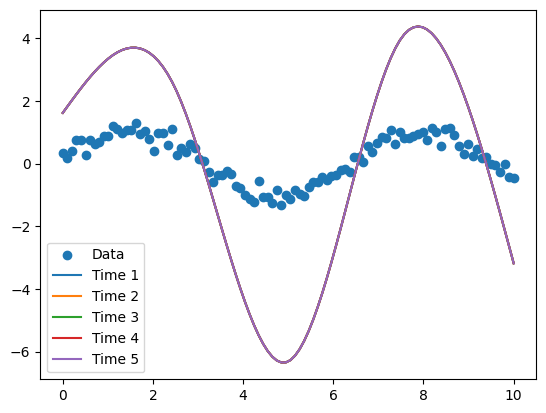

In [ ]:

# Convert pandas DataFrame to R data frame
ro.globalenv['data'] = pandas2ri.py2rpy(data)

# Install and load required R packages
mgcv = importr("mgcv")

# Define the dynamic GAM formula
formula = ro.Formula("y ~ te(X_dyn, k=c(5, 5))")

# Fit the dynamic GAM model
model = mgcv.gam(formula=formula, data=ro.globalenv['data'])

# Get the predicted values
X_new = np.linspace(0, 10, 100)
X_new_dyn = X_new.flatten()
ro.globalenv["X_new_dyn"] = X_new_dyn
y_pred = np.array(mgcv.predict_gam(model, newdata=ro.globalenv))

# Plot the results
import matplotlib.pyplot as plt
plt.scatter(X, y, label='Data')
for i in range(n_timesteps):
    plt.plot(X_new, y_pred, label=f'Time {i+1}')
plt.legend()
plt.show()
